In [1]:
import module_loader
import pandas as pd
from bookirds.curves import *
from bookirds.dual import Dual

In [2]:
nodes = {
    datetime(2022, 1, 1): Dual(1, {"v0": 1}),
    datetime(2024, 1, 1): Dual(1, {"v1": 1}),
    datetime(2027, 1, 1): Dual(1, {"v2": 1}),
    datetime(2032, 1, 1): Dual(1, {"v3": 1}),
    datetime(2052, 1, 1): Dual(1, {"v4": 1}),
    datetime(2072, 1, 1): Dual(1, {"v5": 1}),
}
swaps = {
    Swap2(datetime(2022, 1, 1), 12*2, 12, 12): -0.21,
    Swap2(datetime(2024, 1, 1), 12*3, 12, 12): -0.07,
    Swap2(datetime(2027, 1, 1), 12*5, 12, 12): 0.76,
    Swap2(datetime(2032, 1, 1), 12*20, 12, 12): 1.03,
    Swap2(datetime(2052, 1, 1), 12*20, 12, 12): 0.59,
}
labels = ["2Y", "2Y3Y", "5Y5Y", "10Y20Y", "30Y20Y"]
s_cv = SolvedCurve(nodes=nodes, interpolation="log_linear", swaps=list(swaps.keys()), obj_rates=list(swaps.values()))
s_cv.iterate() 

corr = np.array([
    [1, 0.85, 0.81, 0.75, 0.71],
    [0.85, 1, 0.87, 0.81, 0.81],
    [0.81, 0.87, 1, 0.92, 0.89],
    [0.75, 0.81, 0.92, 1, 0.96],
    [0.71, 0.81, 0.89, 0.96, 1],
])
vol = np.array([15.1, 36.6, 58.6, 68.8, 67.3])
Q = np.matmul(np.matmul(np.diag(vol), corr), np.diag(vol))
mu = np.array([[0, -9.3, -20.4, 1.7, 1.4]]).T 

# First Order Roll/Vol Matrix

In [3]:
sharpe = np.empty((5,5))
sharpe[:] = np.nan
for i in range(4):
    swap = list(swaps.keys())[i]
    a = swap.analytic_delta(s_cv).real
    swap.notional *= -10000 / a
    
    for j in range(i + 1, 5):
        swap2 = list(swaps.keys())[j]
        a = swap2.analytic_delta(s_cv).real
        swap2.notional *= 10000 / a
        
        portfolio = Portfolio([swap, swap2])
        sharpe[j,i] = portfolio.sharpe(s_cv, mu, Q, order=1)
        sharpe[i,j] = -sharpe[j,i]
    
df1 = pd.DataFrame(sharpe[1:, 1:], index=labels[1:], columns=labels[1:])
df1

fwd tolerance reached (gauss_newton) after 2 iterations, func: 9.801429364799605e-26
bck tolerance reached (gauss_newton) after 2 iterations, func: 3.413978781059538e-26
fwd tolerance reached (gauss_newton) after 2 iterations, func: 2.3940741378388237e-26
bck tolerance reached (gauss_newton) after 2 iterations, func: 4.283078087772402e-26
fwd tolerance reached (gauss_newton) after 2 iterations, func: 4.911392298012028e-26
bck tolerance reached (gauss_newton) after 2 iterations, func: 7.050857028681276e-26
fwd tolerance reached (gauss_newton) after 3 iterations, func: 2.05394635371626e-26
bck tolerance reached (gauss_newton) after 3 iterations, func: 2.0515662124537883e-26
fwd tolerance reached (gauss_newton) after 3 iterations, func: 2.0654896074309392e-26
bck tolerance reached (gauss_newton) after 3 iterations, func: 2.0676293926363512e-26


C:\Users\nicol\AppData\Local\Temp\ipykernel_14636\1675348402.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sharpe[j,i] = portfolio.sharpe(s_cv, mu, Q, order=1)


,2Y3Y,5Y5Y,10Y20Y,30Y20Y
2Y3Y,NaN,0.343926,-0.246355,-0.246875
5Y5Y,-0.343926,NaN,-0.807457,-0.709784
10Y20Y,0.246355,0.807457,NaN,0.015540
30Y20Y,0.246875,0.709784,-0.015540,NaN


# Second Order Roll/Vol Matrix

In [4]:
sharpe = np.empty((5,5))
sharpe[:] = np.nan
for i in range(4):
    swap = list(swaps.keys())[i]
    a = swap.analytic_delta(s_cv).real
    swap.notional *= -10000 / a
    
    for j in range(i + 1, 5):
        swap2 = list(swaps.keys())[j]
        a = swap2.analytic_delta(s_cv).real
        swap2.notional *= 10000 / a
        
        portfolio = Portfolio([swap, swap2])
        sharpe[j,i] = portfolio.sharpe(s_cv, mu, Q, order=2)
        sharpe[i,j] = -sharpe[j,i]
    
df2 = pd.DataFrame(sharpe[1:, 1:], index=labels[1:], columns=labels[1:])
df2

C:\Users\nicol\AppData\Local\Temp\ipykernel_14636\980046030.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sharpe[j,i] = portfolio.sharpe(s_cv, mu, Q, order=2)


,2Y3Y,5Y5Y,10Y20Y,30Y20Y
2Y3Y,NaN,0.394908,0.009378,0.175160
5Y5Y,-0.394908,NaN,-0.416263,-0.103637
10Y20Y,-0.009378,0.416263,NaN,0.364249
30Y20Y,-0.175160,0.103637,-0.364249,NaN


# Effect of Gamma on Roll/Vol Matrix

In [5]:
df2 - df1

,2Y3Y,5Y5Y,10Y20Y,30Y20Y
2Y3Y,NaN,0.050982,0.255733,0.422035
5Y5Y,-0.050982,NaN,0.391194,0.606147
10Y20Y,-0.255733,-0.391194,NaN,0.348708
30Y20Y,-0.422035,-0.606147,-0.348708,NaN


# Efficient Frontier and Trade Sampling

In [6]:
N = 40000
sample_risk = (np.random.rand(5, N) - 0.5)*2000
sample_risk[0, :] = 0
sample_risk[:, 0:3]  # display the first 3 samples

array([[   0.        ,    0.        ,    0.        ],
       [ 922.46192758,  538.5369106 ,  504.67343839],
       [ -31.17971661, -615.25020925,  682.57497889],
       [-298.58086986,  569.55381591,  610.23170097],
       [-646.77187461,  938.47071702, -825.35127564]])

Use the simple formula to estimate G

In [7]:
estimator = np.diag([3, 8, 16, 41, 81]) * -1/10000
_ = np.einsum('rn, rj -> rjn', sample_risk, np.eye(5))
sample_gamma = np.einsum('ijn, ij -> ijn', _, estimator)
sample_gamma[:,:,0]  # display estmated gamma for the first sample

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.73796954,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.04988755,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.22418157,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  5.23885218]])

In [8]:
pf = Portfolio()

In [9]:
pnl1 = [pf.exp_pnl(None, mu, Q, order=1, S=sample_risk[:,i], G=sample_gamma[:,:,i]) for i in range(N)]
var1 = [pf.var_pnl(None, mu, Q, order=1, S=sample_risk[:,i], G=sample_gamma[:,:,i]) for i in range(N)]
vol1 = [v ** 0.5 for v in var1]
pnl2 = [pf.exp_pnl(None, mu, Q, order=2, S=sample_risk[:,i], G=sample_gamma[:,:,i]) for i in range(N)]
var2 = [pf.var_pnl(None, mu, Q, order=2, S=sample_risk[:,i][:, np.newaxis], G=sample_gamma[:,:,i]) for i in range(N)]
vol2 = [v ** 0.5 for v in var2]

baseline_risk = np.array([[0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]]).T * -1000
_ = np.einsum('rn, rj -> rjn', baseline_risk, np.eye(5))
baseline_gamma = np.einsum('ijn, ij -> ijn', _, estimator)
pnl_base = [pf.exp_pnl(None, mu, Q, order=2, S=baseline_risk[:,i][:, np.newaxis], G=baseline_gamma[:,:,i]) for i in range(4)]
var_base = [pf.var_pnl(None, mu, Q, order=2, S=baseline_risk[:,i][:, np.newaxis], G=baseline_gamma[:,:,i]) for i in range(4)]
vol_base = [v ** 0.5 for v in var_base]

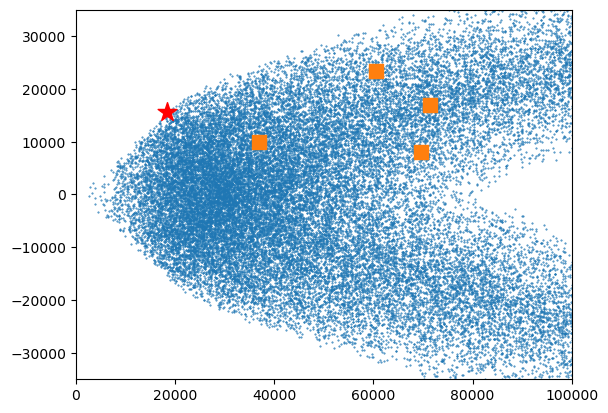

In [10]:
sharpe = np.array([pnl2[i] / vol2[i] for i in range(N)])
best = np.argmax(sharpe)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
# ax.scatter(vol1, pnl1, s=0.2, c="g")
ax.scatter(vol2, pnl2, s=0.2)
ax.scatter(vol_base, pnl_base, s=100.0, marker="s")
ax.scatter(vol2[best], pnl2[best], s=200, marker="*", c="r")
ax.set_xlim(0,1e5)
ax.set_ylim(-35000,35000)
plt.show()

Best risk position assuming roll down as the expected market move is,

In [11]:
pd.DataFrame(sample_risk[:, best], index=labels).style.format("{:,.0f}").applymap(lambda v: "color: red" if v < 0 else "")

C:\Users\nicol\AppData\Local\Temp\ipykernel_14636\4149485110.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pd.DataFrame(sample_risk[:, best], index=labels).style.format("{:,.0f}").applymap(lambda v: "color: red" if v < 0 else "")


,0
2Y,0
2Y3Y,259
5Y5Y,-786
10Y20Y,850
30Y20Y,-384


The Sharpe ratio of this trade is:

In [12]:
pf.sharpe(None, mu, Q, order=1, S=sample_risk[:,best][:, np.newaxis], G= sample_gamma[:,:,best])

array([[[0.83678018]]])